In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# ===============================
# 📌 Import Required Libraries
# ===============================

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import cv2
import seaborn as sns
import random
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from sklearn.model_selection import train_test_split


# ===============================
# 📌 Load Dataset
# ===============================

In [2]:
train_dir = "/kaggle/input/gtsrb-german-traffic-sign/Train"
test_dir = "/kaggle/input/gtsrb-german-traffic-sign/Test"

IMG_SIZE = 64

In [5]:
# --- Load Training Data ---
x_train, y_train = [], []

for class_label in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_label)
    if not os.path.isdir(class_path):
        continue
    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        x_train.append(img)
        y_train.append(int(class_label))

x_train = np.array(x_train)
y_train = np.array(y_train)

In [6]:
# --- Load Test Data ---
df_test = pd.read_csv("/kaggle/input/gtsrb-german-traffic-sign/Test.csv")

x_test, y_test = [], []
for _, row in df_test.iterrows():
    img_file = row['Path']
    img_path = os.path.join("/kaggle/input/gtsrb-german-traffic-sign", img_file)
    img = cv2.imread(img_path)
    if img is None:
        continue
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    x_test.append(img)
    y_test.append(row['ClassId'])

x_test = np.array(x_test)
y_test = np.array(y_test)

print("✅ Train shape:", x_train.shape, y_train.shape)
print("✅ Test shape:", x_test.shape, y_test.shape)


✅ Train shape: (39209, 64, 64, 3) (39209,)
✅ Test shape: (12630, 64, 64, 3) (12630,)


# ===============================
# 📌 Data Preprocessing
# ===============================

In [7]:
# Normalize images
x_train = x_train / 255.0
x_test = x_test / 255.0

In [8]:
# One-hot encode labels
num_classes = len(np.unique(y_train))
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

In [9]:
# Train-validation split
x_train, x_val, y_train_cat, y_val_cat = train_test_split(
    x_train, y_train_cat, test_size=0.2, random_state=42
)

In [10]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
    shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest'
)

# ===============================
# 📌 Custom CNN Model
# ===============================

In [11]:
model_custom = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(256, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1756615520.347768      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1756615520.348475      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [12]:
model_custom.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])


In [13]:
# --- Train Custom CNN ---
history_custom = model_custom.fit(
    datagen.flow(x_train, y_train_cat, batch_size=64),
    validation_data=(x_val, y_val_cat),
    epochs=20,
    steps_per_epoch=len(x_train) // 64
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1756616002.627747      99 service.cc:148] XLA service 0x7914bc002290 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756616002.632924      99 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1756616002.632955      99 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1756616003.426508      99 cuda_dnn.cc:529] Loaded cuDNN version 90300


  4/490 ━━━━━━━━━━━━━━━━━━━━ 24s 51ms/step - accuracy: 0.0251 - loss: 5.9123 

I0000 00:00:1756616009.155612      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


490/490 ━━━━━━━━━━━━━━━━━━━━ 51s 82ms/step - accuracy: 0.2289 - loss: 3.0206 - val_accuracy: 0.5355 - val_loss: 1.5280
Epoch 2/20
  1/490 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.5312 - loss: 1.7699

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5312 - loss: 1.7699 - val_accuracy: 0.5386 - val_loss: 1.5254
Epoch 3/20
490/490 ━━━━━━━━━━━━━━━━━━━━ 34s 69ms/step - accuracy: 0.5933 - loss: 1.2400 - val_accuracy: 0.8532 - val_loss: 0.4339
Epoch 4/20
490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7656 - loss: 0.6383 - val_accuracy: 0.8493 - val_loss: 0.4369
Epoch 5/20
490/490 ━━━━━━━━━━━━━━━━━━━━ 34s 70ms/step - accuracy: 0.7829 - loss: 0.6647 - val_accuracy: 0.9104 - val_loss: 0.2603
Epoch 6/20
490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8125 - loss: 0.5444 - val_accuracy: 0.9137 - val_loss: 0.2548
Epoch 7/20
490/490 ━━━━━━━━━━━━━━━━━━━━ 34s 69ms/step - accuracy: 0.8619 - loss: 0.4154 - val_accuracy: 0.9180 - val_loss: 0.2265
Epoch 8/20
490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8750 - loss: 0.5616 - val_accuracy: 0.9185 - val_loss: 0.2269
Epoch 9/20
490/490 ━━━━━━━━━━━━━━━━━━━━ 34s 70ms/step - accuracy: 0.8901 - loss: 0.3213 - val_accuracy: 0.962

In [25]:
# --- Evaluate Custom CNN ---
loss_custom, acc_custom = model_custom.evaluate(x_test, y_test_cat, verbose=0)
print(f"\n🎯 Custom CNN Accuracy: {acc_custom:.4f}")



🎯 Custom CNN Accuracy: 0.9249


# ===============================
# 📌 MobileNetV2 (Transfer Learning)
# ===============================

In [16]:
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

/tmp/ipykernel_36/3926724613.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))


In [17]:
# Unfreeze last 20 layers
for layer in base_model.layers[-20:]:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
preds = Dense(num_classes, activation="softmax")(x)

model_mobilenet = Model(inputs=base_model.input, outputs=preds)

model_mobilenet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                        loss="categorical_crossentropy",
                        metrics=["accuracy"])

In [18]:
# --- Train MobileNet ---
history_mobilenet = model_mobilenet.fit(
    datagen.flow(x_train, y_train_cat, batch_size=64),
    validation_data=(x_val, y_val_cat),
    epochs=20,
    steps_per_epoch=len(x_train) // 64
)

Epoch 1/20


E0000 00:00:1756616598.164395      97 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1756616598.300008      97 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


  1/490 ━━━━━━━━━━━━━━━━━━━━ 7:14:51 53s/step - accuracy: 0.0469 - loss: 4.6112

E0000 00:00:1756616615.156869      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1756616615.290916      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


490/490 ━━━━━━━━━━━━━━━━━━━━ 114s 124ms/step - accuracy: 0.1898 - loss: 3.3039 - val_accuracy: 0.3030 - val_loss: 3.0583
Epoch 2/20
490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6094 - loss: 1.3295 - val_accuracy: 0.3043 - val_loss: 3.0540
Epoch 3/20
490/490 ━━━━━━━━━━━━━━━━━━━━ 37s 76ms/step - accuracy: 0.5837 - loss: 1.3845 - val_accuracy: 0.5851 - val_loss: 1.8444
Epoch 4/20
490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6406 - loss: 0.9715 - val_accuracy: 0.5838 - val_loss: 1.8629
Epoch 5/20
490/490 ━━━━━━━━━━━━━━━━━━━━ 37s 76ms/step - accuracy: 0.7616 - loss: 0.7348 - val_accuracy: 0.7766 - val_loss: 0.9123
Epoch 6/20
490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8281 - loss: 0.4792 - val_accuracy: 0.7766 - val_loss: 0.9080
Epoch 7/20
490/490 ━━━━━━━━━━━━━━━━━━━━ 37s 76ms/step - accuracy: 0.8487 - loss: 0.4523 - val_accuracy: 0.8906 - val_loss: 0.3560
Epoch 8/20
490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8125 - loss: 0.5554 - val_accuracy: 0.8

In [19]:
# --- Evaluate MobileNet ---
loss_mobilenet, acc_mobilenet = model_mobilenet.evaluate(x_test, y_test_cat)
print(f"\n🎯 MobileNetV2 Accuracy: {acc_mobilenet:.4f}")

395/395 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9136 - loss: 0.3113

🎯 MobileNetV2 Accuracy: 0.9097


# ===============================
# 📌 MobileNetV2 Results
# ===============================

395/395 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step


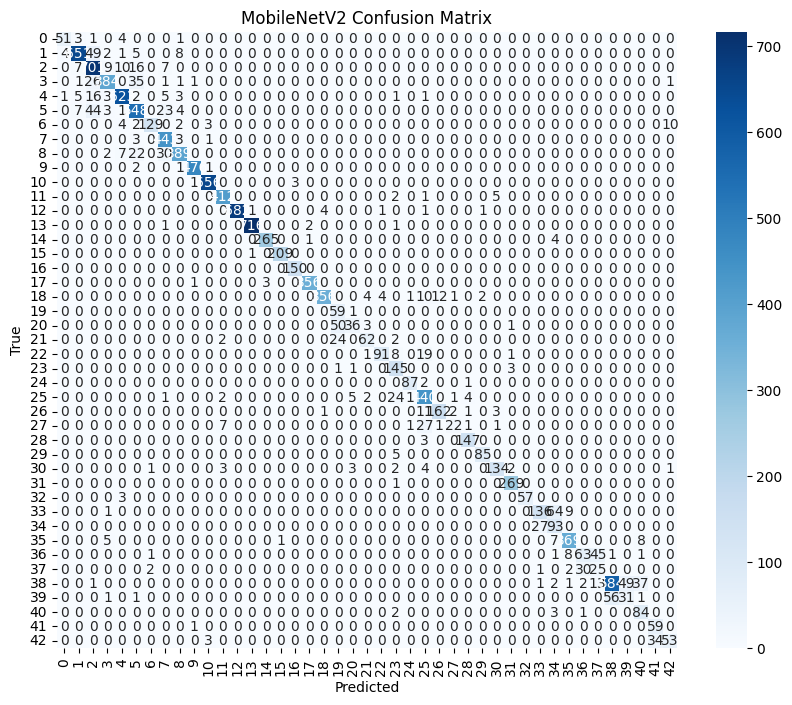

In [20]:
# Confusion Matrix
y_pred_mobilenet = np.argmax(model_mobilenet.predict(x_test), axis=1)
cm_mobilenet = confusion_matrix(y_test, y_pred_mobilenet)

plt.figure(figsize=(10,8))
sns.heatmap(cm_mobilenet, annot=True, fmt='d', cmap='Blues')
plt.title('MobileNetV2 Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

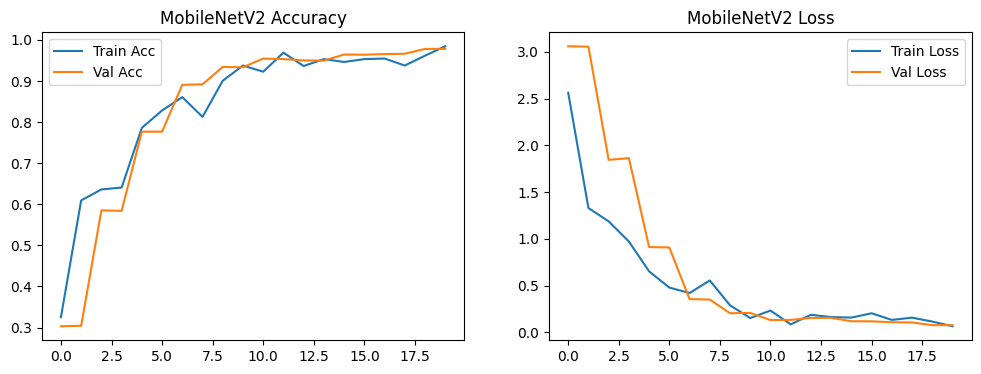

In [21]:
# Accuracy & Loss Curves
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_mobilenet.history['accuracy'], label='Train Acc')
plt.plot(history_mobilenet.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('MobileNetV2 Accuracy')

plt.subplot(1,2,2)
plt.plot(history_mobilenet.history['loss'], label='Train Loss')
plt.plot(history_mobilenet.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('MobileNetV2 Loss')
plt.show()

# ===============================
# 📌 Final Performance Comparison
# ===============================

In [26]:
print("\n📊 Performance Comparison:")
print(f"✅ Custom CNN Test Accuracy: {acc_custom:.4f}")
print(f"✅ MobileNetV2 Test Accuracy: {acc_mobilenet:.4f}")


📊 Performance Comparison:
✅ Custom CNN Test Accuracy: 0.9249
✅ MobileNetV2 Test Accuracy: 0.9097
